In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt
import seaborn as sns #for better and easier plots
%matplotlib inline

import os
print(os.listdir("../input"))


import warnings
warnings.filterwarnings(action="ignore")

['heart.csv']


**> First step is to load the data and then take a overall look at the features**

In [49]:
data = pd.read_csv("../input/heart.csv")

In [50]:
print("Shape of the data: ", data.shape) #printing out the shape of data, 303x14

Shape of the data:  (303, 14)


In [51]:
data.head()#let's use .head() and see what the data has for us.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


So now, let's take a look at the null values we have in our data, I am gonna define a function that's gonna help us whenever it's needed to check for null values.

In [52]:
#only shows null values. 
## shows the percentage of null values
def missing_values_calculate(trainset): 
    nulldata = (trainset.isnull().sum() / len(trainset)) * 100
    nulldata = nulldata.drop(nulldata[nulldata == 0].index).sort_values(ascending=False)
    ratio_missing_data = pd.DataFrame({'Ratio' : nulldata})
    return ratio_missing_data.head(30)

In [53]:
missing_values_calculate(data) #calling the function to check the data

,Ratio


**That's fun, no null values**

In [54]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

**Gonna describe briefly the columns below**
* **age** in years
* **sex** (1 = male; 0 = female)
* **cp**  chest pain type(angina)
* **trestbpsm** resting blood pressure (in mm Hg on admission to the hospital)
* **chol** serum cholestoral in mg/dl
* **fbs** (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* **restecgresting** electrocardiographic results
* **thalach** maximum heart rate achieved
* **exang** exercise induced angina (1 = yes; 0 = no)
* **oldpeakST** depression induced by exercise relative to rest
* **slope** the slope of the peak exercise ST segment
* **ca** number of major vessels (0-3) colored by flourosopy
* **thal** 3 = normal/ 6 = fixed defect /7 = reversable defect
* **target** 1 or 0

In [55]:
data.dtypes #let's take a look at the types of each column

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

all numerical data, as it has been prepared for this, ready for preparing and fitting to models.

**Some data exploration, let's have some fun**

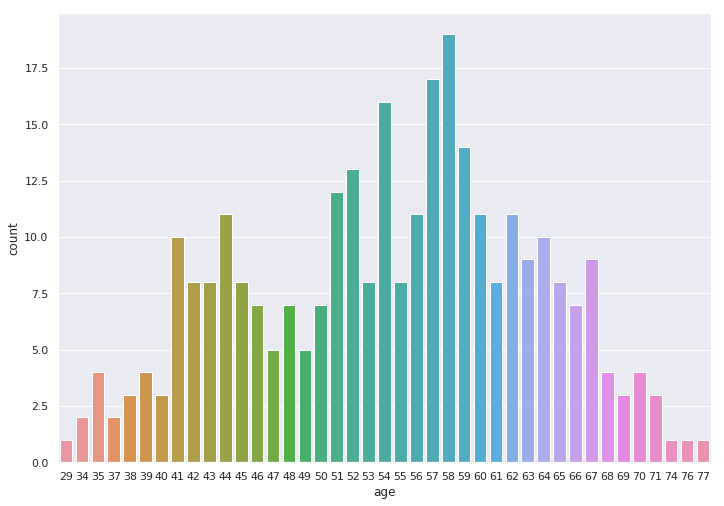

In [56]:
sns.set(rc={'figure.figsize':(11.7,8.27)}) #setting the size of the figure to make it easier to read.
sns.countplot(data["age"]) #age seems to have a positive correlation to the chance of heart disease.

**by looking at the plot, we have a normal distribution, after 59 years old, your chance of heart disease decreases**

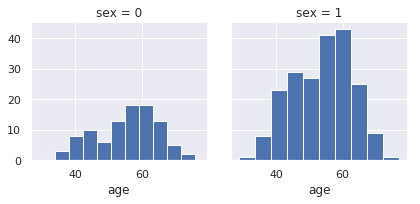

In [57]:
g = sns.FacetGrid(data, col="sex")
g.map(plt.hist, "age")

In [58]:
data['sex'].value_counts() #in this given data, we have a significantly assymetry in gender, way more mens.

1    207
0     96
Name: sex, dtype: int64

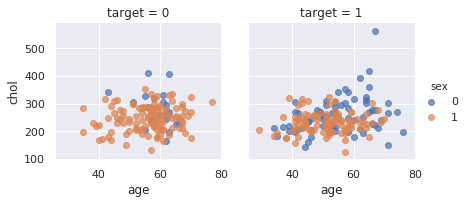

In [59]:
g = sns.FacetGrid(data, col="target", hue="sex")
g.map(plt.scatter, "age", "chol", alpha=.7)
g.add_legend()

**Contrary to the common sense, High colesterol doesn't seems to correlate significantly with a higher risk of heart disease**
PS: we have one outlier, for the group of men, above 500 cholesterol, men and target 1

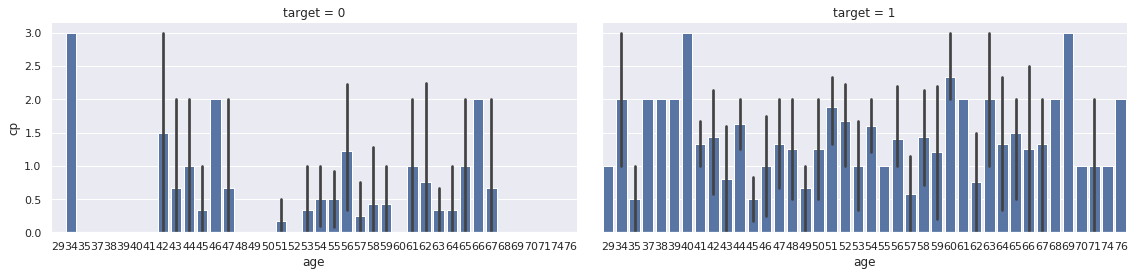

In [60]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.FacetGrid(data, col="target", height=4, aspect=2)
g.map(sns.barplot, "age", "cp")# I would like to see how chest pain is distributed in relationship to the target and age

Angina appears way more in our right plot, target 0, It seems to be a good indicator of target 0/1

In [61]:
corr = data.corr() #let's take a look at pearson's correlation
corr['target'].sort_values(ascending=False)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

The pearson's correlation give us some insights;
* as seen, chest pain is positively correlated to the target
* thalach, highest heart rate registered, is as well positively correlated to our target
* we have also some negatively correlated values, such as, ca, oldpeak and exang, which are, respectivelly, number of major vessels(ca), the oldpeak during exercise and the slope, depression, after exercise(as measured in a test)

**Let's now split the data using the stratified method, trying to keep the data more approximately distributed as the original**

In [62]:
#we can use the following sklearn method to create a training and testing sample that is stratified.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #20% for the testing sample
for train_index, test_index in split.split(data, data["sex"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [63]:
print(strat_train_set.shape, strat_test_set.shape, data.shape) # let's check the shape of the datasets created

(242, 14) (61, 14) (303, 14)


In [64]:
#now, I am gonna create Xtrain, Ytrain, Xtest, Ytest
Xtrain = strat_train_set.drop('target', axis=1).copy()
Ytrain = strat_train_set['target'].copy()
Xtest = strat_test_set.drop('target', axis=1).copy()
Ytest = strat_test_set['target'].copy()

In [65]:
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape) #And again, let's check the final shape of our datasets.

(242, 13) (242,) (61, 13) (61,)


In [66]:
#Gonna create a simple pipeline, for imputing future values, if NaN and standard scalling
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#this is a class to make selection of numerical atributes elegant and simple.   
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [67]:
#and finally, I am gonna create this function and use it to apply different model and see the results, accuracy, recal and F1 score
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

#Generic function for making a classification model and accessing performance:
def classification_model(model, X_train, y_train):
    #Fit the model:
    model.fit(X_train,y_train)
    n_cache = []
    
    train_predictions = model.predict(X_train)
    precision = precision_score(y_train, train_predictions)
    recall = recall_score(y_train, train_predictions)
    f1 = f1_score(y_train, train_predictions)
    
    print("Precision ", precision)
    print("Recall ", recall)
    print("F1 score ", f1)

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
        
    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(cv_score)))

**I am gonna run the pipeline and prepare the data, I could(or should)have created a pipeline that receives the model automatically and fit the data, I am gonna implement it later**

In [69]:
#Xtrain = num_pipeline.fit_transform(Xtrain) you might want to turn on the pipeline to see whether it fits better to our model
#Xtest_prepared = num_pipeline.fit_transform(Xtest)

In [71]:
#ok, let's take a look at our fist model.
#stochastic gradient descent SGD

##Note: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as max_iter and tol. 
##To be future-proof, we explicitly set these hyperparameters to their future default values.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
classification_model(sgd_clf,Xtrain,Ytrain)

Precision  0.5654008438818565
Recall  1.0
F1 score  0.7223719676549865
Cross-Validation Score : 67.689%


** by using our function, we had a CV of 74% and F1 75%, let's dig deeper**

In [72]:
#Now, logistic regression...
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="liblinear")
classification_model(log_reg, Xtrain, Ytrain)

Precision  0.825503355704698
Recall  0.917910447761194
F1 score  0.8692579505300354
Cross-Validation Score : 83.866%


**way better, don't you think? Our CV is now 82%**

In [75]:
#gonna use the decision tree without specifying any parameter, it's very likely to overfit the data, however, I am gonna use it
##to take a look at feature importances and plot a graph using it.
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
classification_model(tree_reg, Xtrain, Ytrain)

Precision  1.0
Recall  1.0
F1 score  1.0
Cross-Validation Score : 76.905%


**just as I said, It's overfitting. And it was expected. now let's take a look at features importance and see how it looks**

Text(0.5, 1.0, 'Variable Importance')

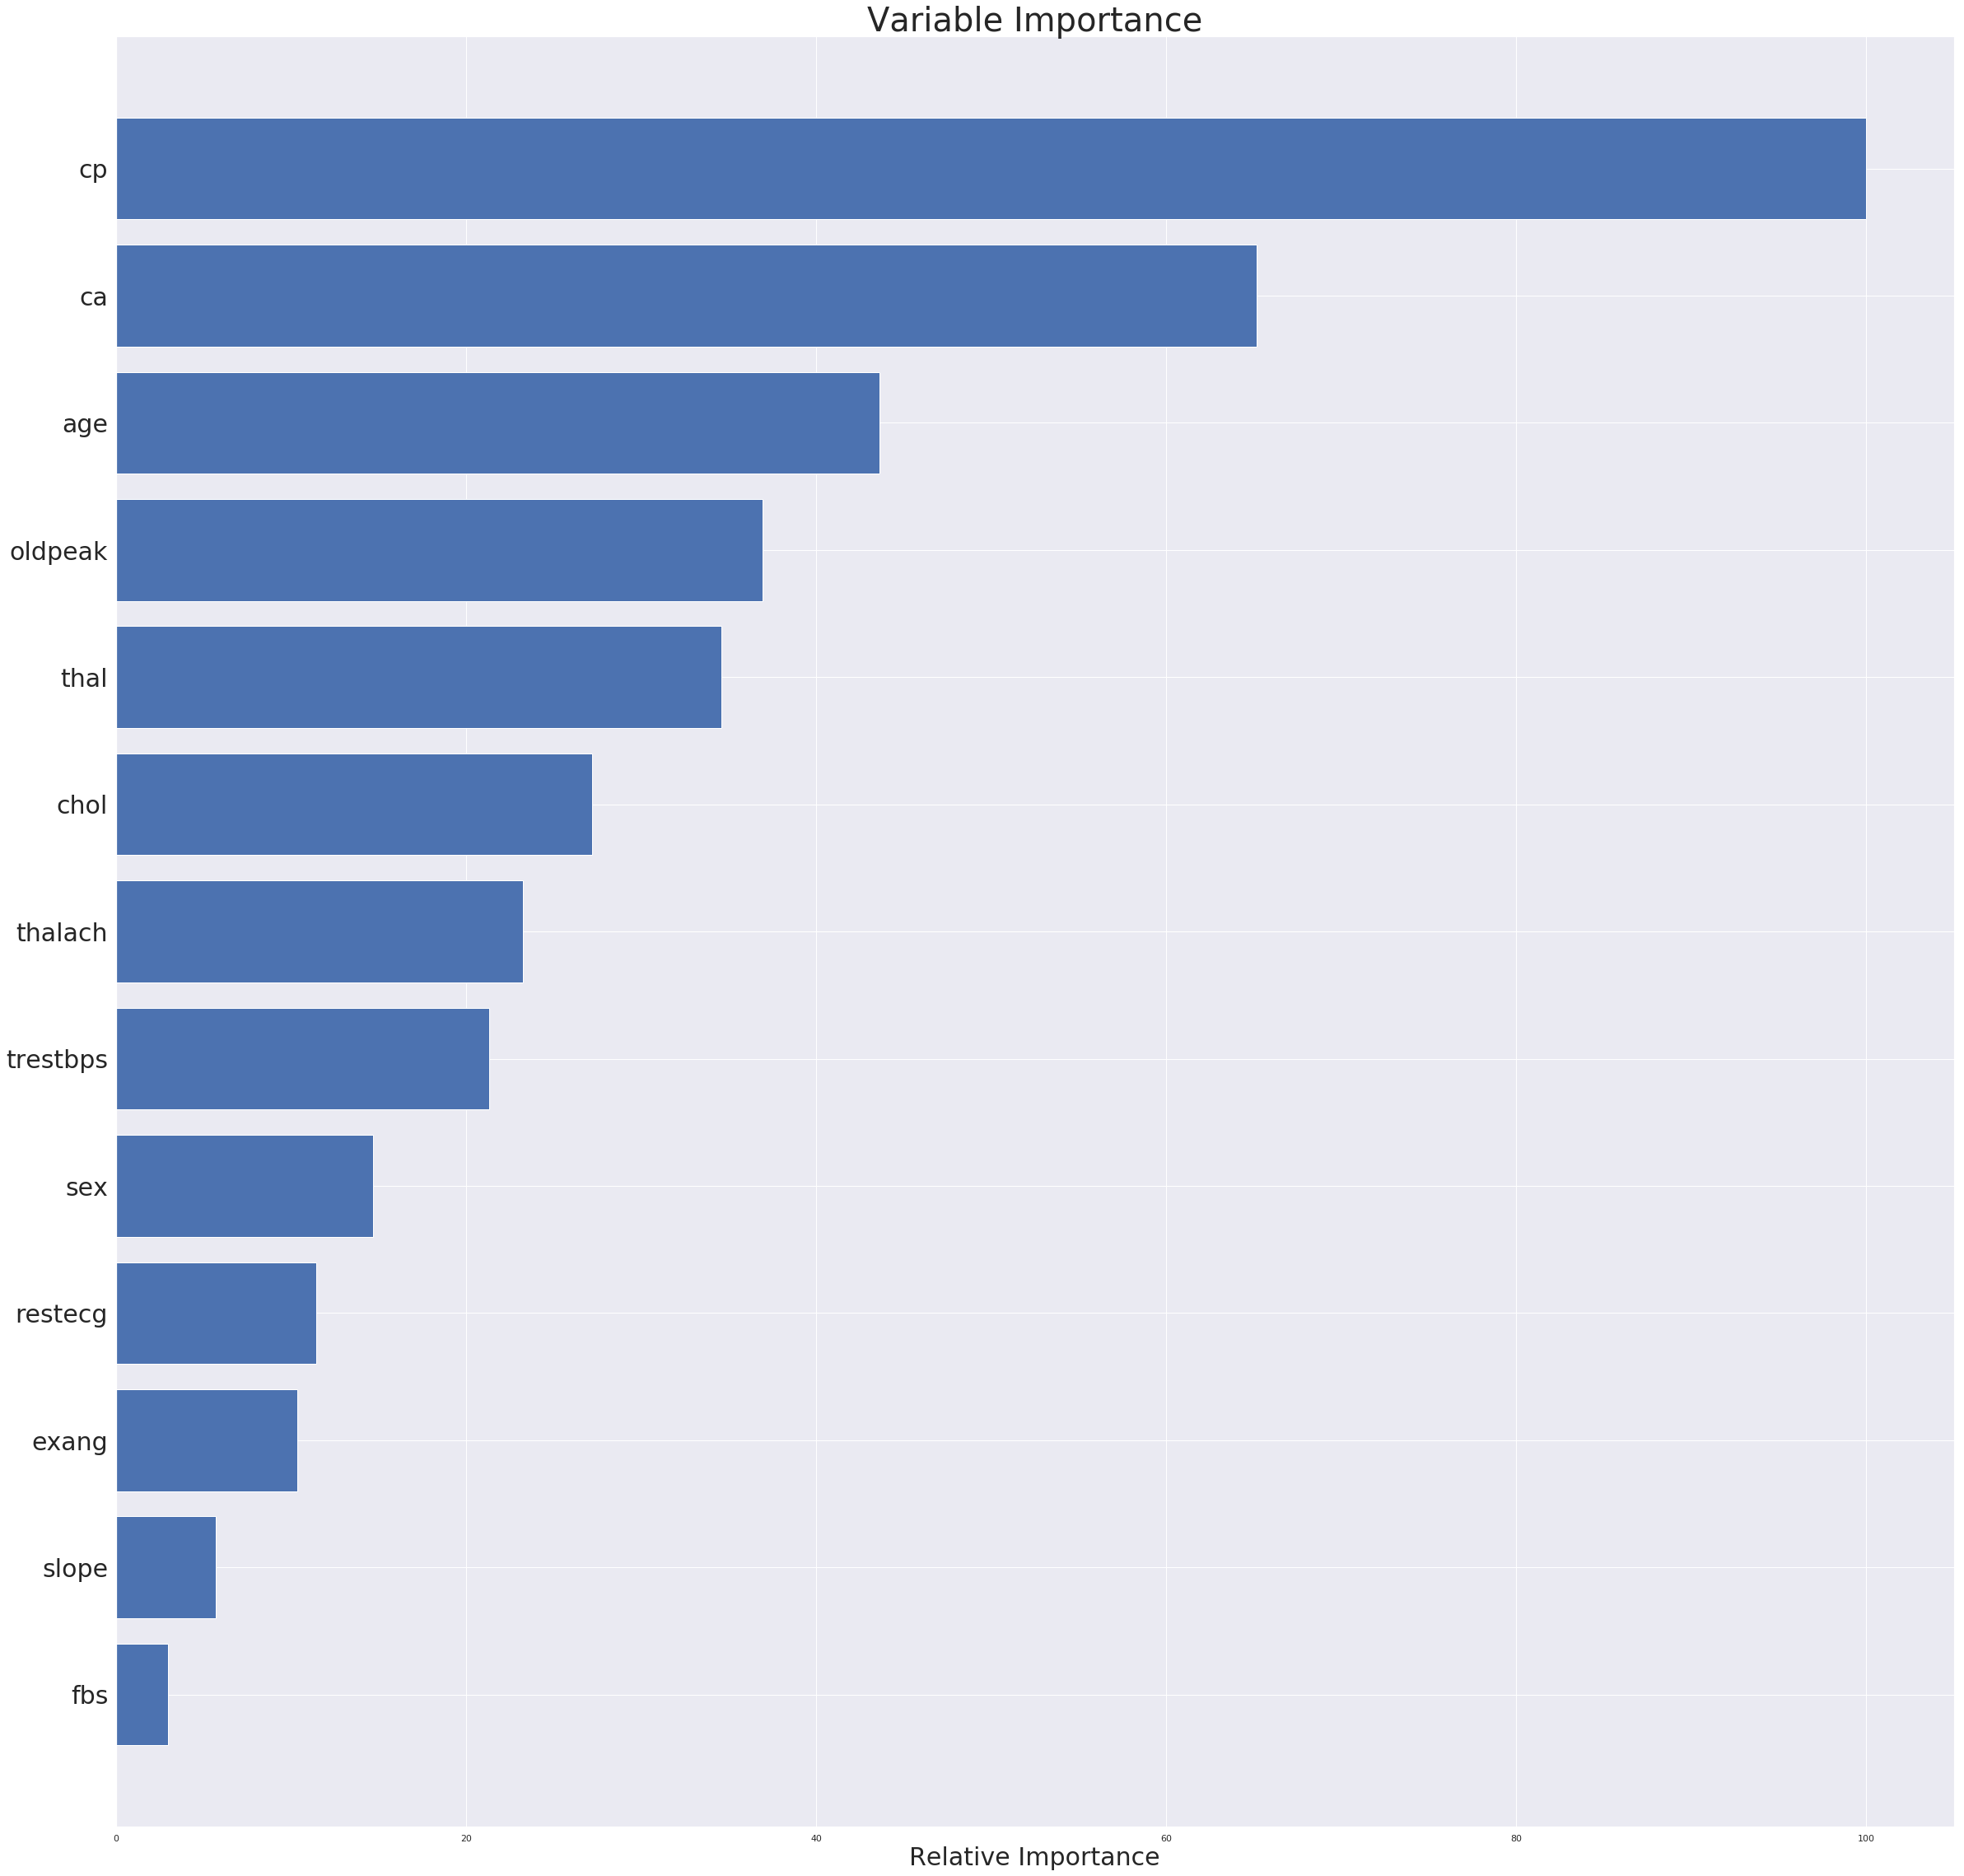

In [76]:
# Plot feature importance
feature_importance = tree_reg.feature_importances_
# make importances relative to max importance
plt.figure(figsize=(40, 40))
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, strat_train_set.columns[sorted_idx], fontsize=30)
plt.xlabel('Relative Importance', fontsize=30)
plt.title('Variable Importance', fontsize=40)

**As the pearson's correlation revealed before, chest pain is the most important feature for our dataset **

In [77]:
#Gradient Boosting for classification.

from sklearn.ensemble import GradientBoostingClassifier
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.005, 'loss': 'deviance'}

clf = GradientBoostingClassifier(**params)
classification_model(clf, Xtrain, Ytrain)

Precision  0.9849624060150376
Recall  0.9776119402985075
F1 score  0.9812734082397004
Cross-Validation Score : 81.843%


**Gradient descent boosting, gonna use grid_search later in order to get parameters**

In [78]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=200, random_state=42)
classification_model(forest_clf, Xtrain, Ytrain)

Precision  1.0
Recall  1.0
F1 score  1.0
Cross-Validation Score : 82.650%


**The highest Cross Value so far, which might be improved later with grid_search, searching for better hyper parameters.**

The following part was inspired by a post here [here](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model)

Before reading it, I hadn't be aware of the permutation package and how to use it.

In [79]:
#let's train a rather simple neural network
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=42)
classification_model(mlp_clf, Xtrain, Ytrain)

Precision  0.8439716312056738
Recall  0.8880597014925373
F1 score  0.8654545454545455
Cross-Validation Score : 70.223%


Now let's see how the famous XGboost performs in this dataset. Gradient boosting on steroids.

In [80]:
import xgboost #importing the package

extra_parameters = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 5,
                        "min_child_weight": 3, 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 1.0,
                        'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 27
                   }

xgb_clf = xgboost.XGBClassifier(random_state=42)
classification_model(xgb_clf, Xtrain, Ytrain)

Precision  0.9925373134328358
Recall  0.9925373134328358
F1 score  0.9925373134328358
Cross-Validation Score : 82.668%


In [81]:
#Gonna implement an ensemble model using the voting classifier
from sklearn.ensemble import VotingClassifier

#gonna create a list to help us put together the models and give it a name.

named_estimators = [
    #("sgd_clf", sgd_clf),
    #("random_forest_clf", forest_clf),
    #("gdb_clf", clf),
    #("mlp_clf", mlp_clf),
    ("logistic", log_reg),
    ("xboost", xgb_clf),
]

In [82]:
voting_clf = VotingClassifier(named_estimators)
#voting_clf.fit(Xtrain, Ytrain)
classification_model(voting_clf, Xtrain, Ytrain)

Precision  0.9919354838709677
Recall  0.917910447761194
F1 score  0.9534883720930232
Cross-Validation Score : 83.892%


** a rather small increase upon using the voting classifier, but still, an improvement. let's keep going on...**

In [83]:
#importing relevant modules for this part
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
#from pdpbox import pdp, info_plots #for partial plots

In [86]:
# I am gonna try first with de Gradient Boosting model, 
##And then with the Random forest model, just to see the difference, if any
perm = PermutationImportance(log_reg, random_state=1).fit(Xtest, Ytest) #gonna use logistic regression here, as the voting classifier seems to no work properly
eli5.show_weights(perm, feature_names = Xtest.columns.tolist())

Weight,Feature
0.0656 ± 0.0359,cp
0.0262 ± 0.0262,sex
0.0230 ± 0.0491,oldpeak
0.0164 ± 0.0293,ca
0.0131 ± 0.0564,thal
0.0098 ± 0.0675,thalach
0.0066 ± 0.0161,age
0.0000 ± 0.0207,exang
0.0000 ± 0.0293,restecg
0 ± 0.0000,fbs


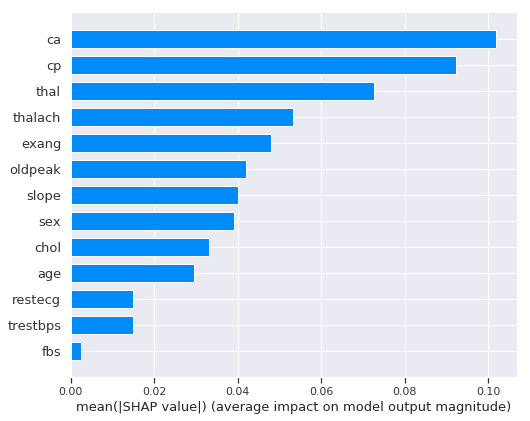

In [90]:
explainer = shap.TreeExplainer(forest_clf) #using the random forest as shap seems to no support the voting classifier
shap_values = explainer.shap_values(Xtest)

shap.summary_plot(shap_values[1], Xtest, plot_type="bar")

**Again, picking from the same article as a mentioned before, gonna use the function below to apply to single individuals and measure the risk of heart disease**

In [91]:
def heart_disease_risk_factors(model, patient):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [92]:
#let's get a patience and take a look at the shap force plot.
p = 7 #helping variable, easily specify different patients.
data_for_prediction = Xtest.iloc[p,:].astype(float) #as I am using pipeline, I am using different datasets in order
heart_disease_risk_factors(forest_clf, data_for_prediction)#again, I am using the random forest model. 
#unfortunately, not all the models used can be used for the shap force plot